MIT License

Copyright (c) 2023 Pavel Shibanov [https://blog.experienced.dev/](https://blog.experienced.dev/turn-1c-into-a-startup-idea-landing-page-using-langchain-chatgpt/?utm_source=notebooks)

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

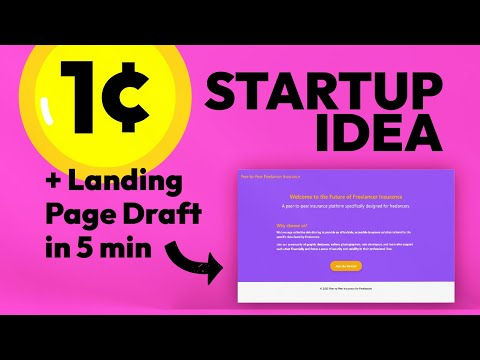

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo("Zqqz5GFcY3A", width="560", height="315")

In [2]:
from IPython.display import display, HTML

display(
    HTML(
        '<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Excited to share a Google Colab notebook that transforms just 1¢ worth of tokens into a startup idea and an HTML landing page draft, using <a href="https://twitter.com/LangChainAI?ref_src=twsrc%5Etfw">@LangChainAI</a> and <a href="https://twitter.com/OpenAI?ref_src=twsrc%5Etfw">@OpenAI</a>. <a href="https://twitter.com/hashtag/AI?src=hash&amp;ref_src=twsrc%5Etfw">#AI</a> <a href="https://twitter.com/hashtag/startup?src=hash&amp;ref_src=twsrc%5Etfw">#startup</a> <a href="https://twitter.com/hashtag/startups?src=hash&amp;ref_src=twsrc%5Etfw">#startups</a> <a href="https://twitter.com/hashtag/ChatGPT?src=hash&amp;ref_src=twsrc%5Etfw">#ChatGPT</a> <a href="https://twitter.com/hashtag/langchain?src=hash&amp;ref_src=twsrc%5Etfw">#langchain</a><a href="https://t.co/eLrP2hZABe">https://t.co/eLrP2hZABe</a></p>&mdash; Pavel Shibanov (@shibanovp) <a href="https://twitter.com/shibanovp/status/1670198229294542849?ref_src=twsrc%5Etfw">June 17, 2023</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>'
    )
)

In [ ]:
%pip install -q python-dotenv==1.0.0 langchain==0.0.201 openai==0.27.8 pytrends

In [ ]:
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

In [ ]:
# @title Idea PromptTemplate
# @markdown Feel free to modify it if you want to generate ideas in a different way.
from langchain.prompts import ChatPromptTemplate

generate_idea_prompt_template = ChatPromptTemplate.from_template(
    """
    Generate an innovative and feasible startup idea in {industry}
    that requires an initial investment of under ${budget}.
    Briefly explain the core concept of the idea, potential customers,
    and how it could generate revenue.
    """
)

In [ ]:
# @title Idea Parameters { run: "auto", display-mode: "form" }
from IPython.display import display, Markdown

industry = "Insurance"  # @param ["Information Technology", "Automotive", "Financial Services", "Energy", "Telecommunications", "Retail", "Construction", "Manufacturing", "Aerospace", "Food and Beverage", "Pharmaceuticals", "Media and Entertainment", "Insurance", "Transportation", "Hospitality", "Real Estate", "Education", "Utilities", "Mining"] {allow-input: true}
budget = 1000  # @param {type:"number"}

generate_idea = generate_idea_prompt_template.format_messages(
    budget=budget, industry=industry
)
display(Markdown(generate_idea[0].content))

In [ ]:
# @title LLM Configuration { run: "auto", display-mode: "form" }

import os
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain

# @markdown You can obtain your own API key from [openai.com](https://platform.openai.com/account/api-keys).\
# @markdown Once you have it, you can either paste it here or set it as your OPENAI_API_KEY environment variable.
openai_api_key = "sk-..."  # @param {type:"string"}
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY", openai_api_key)
# @markdown If you have access to the gpt-4-0613 model, selecting it could yield even better results.
model = "gpt-3.5-turbo-0613"  # @param ["gpt-3.5-turbo-0613","gpt-4-0613"]
# @markdown In this context, 'temperature' adjusts the output from being predictable to being more random. Feel free to experiment with this parameter to achieve more creative results.
temperature = 1.3  # @param {type:"slider", min:0, max:2, step:0.1}
# temperature = 0.0
llm = ChatOpenAI(temperature=temperature, model=model)
f"{model=} {temperature=}"

In [ ]:
# @title Generate an Idea
from IPython.display import display, Markdown

idea = llm(generate_idea)
display(Markdown(idea.content))

In [ ]:
# @title Generate SEO keywords { run: "auto", display-mode: "form" }
# @markdown Number of keywords to generate
num_keywords = 3  # @param {type: "number"}
# @markdown I prefer to keep this temperature close to zero. Increase it if you would like to get more creative with keywords.
temperature_for_keywords = 0  # @param {type:"slider", min:0, max:2, step:0.1}
llm = ChatOpenAI(temperature=temperature_for_keywords, model=model)
f"{num_keywords=} {temperature_for_keywords=}"

In [ ]:
# @title Keywords PromptTemplate
# @markdown Feel free to modify it if you wish to generate keywords in a different manner.
get_keywords_prompt_template = ChatPromptTemplate.from_template(
    """
    Generate a list of {num_keywords} SEO keywords for a startup idea:
    ```
    {idea}
    ```
    """
)
get_keywords_messages = get_keywords_prompt_template.format_messages(
    num_keywords=num_keywords, idea=idea
)

In [ ]:
# @title get_seo_keywords Function definition
# @markdown Learn more about function calling at [OpenAI](https://openai.com/blog/function-calling-and-other-api-updates#function-calling)
from langchain.schema import HumanMessage
import json

functions = [
    {
        "name": "get_seo_keywords",
        "description": "Get seo keywords for the startup idea",
        "parameters": {
            "title": "Get seo keywords for the startup idea",
            "description": "Input for get seo keywords for the startup idea",
            "type": "object",
            "properties": {
                "keywords": {
                    "title": "Seo keywords",
                    "description": "List of SEO keywords",
                    "type": "array",
                    "items": {"type": "string"},
                },
            },
            "required": ["keywords"],
        },
    }
]

message = llm.predict_messages(get_keywords_messages, functions=functions)
print(message.additional_kwargs["function_call"])
function_call = json.loads(message.additional_kwargs["function_call"]["arguments"])
function_call
kw_list = function_call["keywords"][:num_keywords]
print(f"{kw_list=}")

In [ ]:
# @markdown To use your own or refined keywords, uncomment the next line.
# kw_list=['keyword', 'keyword2', 'keyword3']

In [ ]:
# @title Google Trends last 12 months with [pytrends](https://github.com/GeneralMills/pytrends)
# @markdown Errors occurring in this step could indicate a variety of issues. If this happens, start by looking at the [docs](https://github.com/GeneralMills/pytrends#caveats). However, remember that you can safely skip this step and proceed to generate your landing page.
from pytrends.request import TrendReq

keywords = ", ".join(kw_list)
print(f"{keywords=}")
pytrends = TrendReq(hl="en-US", tz=360)
pytrends.build_payload(kw_list, cat=0, timeframe="today 12-m", geo="", gprop="")
interest = pytrends.interest_over_time()
interest.plot();

In [ ]:
# @markdown You can work with the returned dataframe.
# interest.describe()

In [ ]:
# @title Landing Page Generation Parameters { run: "auto", display-mode: "form" }
# @markdown I prefer to keep this temperature close to zero. Increasing it might result in made-up HTML tags, among other things.
temperature_for_html = 0  # @param {type:"slider", min:0, max:2, step:0.1}
llm = ChatOpenAI(temperature=temperature_for_html, model=model)
# @markdown Email you would like to use
email = "do-not-reply@example.com"  # @param {"type": "string"}
f"{temperature_for_html=} {email}"

In [ ]:
# @title Generate Landing Page
get_landing_page = ChatPromptTemplate.from_template(
    """
    Create an HTML5 startup landing page using Tailwind CSS, optimized for the following keywords: "{keywords}", with a Join the Waitlist maito:{email} button, for the idea:
    ```
    {idea}
    ```
    """
)
get_landing_page_messages = get_landing_page.format_messages(
    keywords=keywords, idea=idea, email=email
)
message = llm.predict_messages(get_landing_page_messages)

from IPython.display import display, HTML

display(HTML(message.content))

In [ ]:
# @title Download Your Landing Page
from google.colab import files

with open("index.html", "w") as file:
    file.write(message.content)
files.download("index.html")